In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import numpy as np
import json
import math
import os

In [ ]:
DATASET_PATH = "./Datasets/musiccaps-public.csv"
OUTPUT_PKL_PATH = "./fixed_caption_melspectrogram.pkl"


df = pd.read_csv(DATASET_PATH)
df.head(5)
#ytid               youtube vdo-id
#start-end          start-end clip of yt video
#positive_labels    Labels for this segment from the AudioSet (https://research.google.com/audioset/) dataset.
#aspect-list        tags for the clips
#caption            caption for the clips
#author_id          An integer for grouping samples by who wrote them (the captions).
#is_balanced_subset If this value is true, the row is a part of the 1k subset which is genre-balanced on audioset ds.
#is_audioset_eval   If this value is true, the clip is from the AudioSet eval split. Otherwise it is from the AudioSet train split.

,ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval
0,-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...,4,False,True
1,-0SdAVK79lg,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...","['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...,0,False,False
2,-0vPFx-wRRI,30,40,"/m/025_jnm,/m/04rlf","['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...,6,False,True
3,-0xzrMun0Rs,30,40,"/m/01g90h,/m/04rlf","['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...,6,False,True
4,-1LrH01Ei1w,30,40,"/m/02p0sh1,/m/04rlf","['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,0,False,False


In [ ]:
df = df[['ytid','aspect_list','caption']] #retrieve only necessary columns.
df.head(5)

,ytid,aspect_list,caption
0,-0Gj8-vB1q4,"['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...
1,-0SdAVK79lg,"['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...
2,-0vPFx-wRRI,"['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...
3,-0xzrMun0Rs,"['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...
4,-1LrH01Ei1w,"['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...


In [ ]:
HOP_LENGTH = 1024 #HOP_LENGTH FOR WINDOWING
FRAME_SIZE = 4096 #COMMON FRAME_SIZE 4XHOP_LENGTH
N_MELS = 128      #NUMBER OF MEL_BANDS
SR = 16000        #SAMPLING RATE
AUDIO_DIR = "./Datasets/gmusiccaps"

def assign_mel_spec(ytid):
    file_path =  os.path.normpath(os.path.join(AUDIO_DIR,f"{ytid}.wav"))
    print(f"processing ytid : {ytid}")
    if(os.path.exists(file_path)):
        signal,sr = librosa.load(file_path,sr=SR)
        mel_spec =  librosa.feature.melspectrogram(y=signal,
                          sr=SR,
                          n_fft=FRAME_SIZE,
                          hop_length=HOP_LENGTH,
                          n_mels=N_MELS,
                          window="hann")
        mel_spec_db = librosa.power_to_db(mel_spec)
        return mel_spec_db
    else:
        return "404"

df = df.assign(mel_spectrogram=lambda rows : rows['ytid'].apply(assign_mel_spec))


In [ ]:
# drop rows which has no valid spectrogram
df = df.loc[df['mel_spectrogram'] != "404" ]
df.shape

E:\MLS\RTI\Lib\site-packages\pandas\core\ops\array_ops.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


(5491, 4)

In [ ]:
df = df.reset_index()
df.to_pickle(OUTPUT_PKL_PATH)

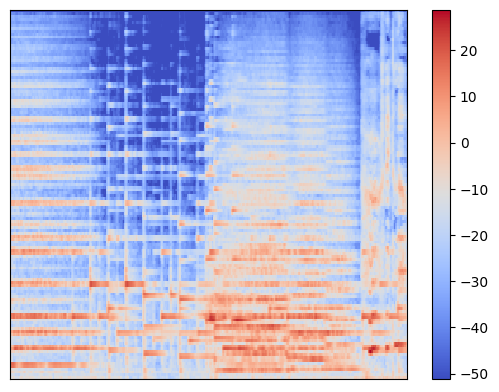

In [ ]:
librosa.display.specshow(df.loc[0]['mel_spectrogram'],sr=SR)
plt.colorbar()

In [ ]:
df['mel_spectrogram']

0       [[-14.097406, -11.082294, -8.232725, -10.62423...
1       [[-2.7312694, -1.5929137, -2.828573, -2.417910...
2       [[-12.465161, -14.239837, -10.702349, -10.1056...
3       [[-3.4610844, -5.621482, -4.4565024, -4.377099...
4       [[11.892473, 11.391735, 10.117396, 9.940582, 1...
                              ...                        
5486    [[-10.806789, -8.273593, 6.369691, 17.9512, 16...
5487    [[-11.485344, -13.494253, -16.17632, -15.99739...
5488    [[-20.852879, -22.620104, -24.4223, -25.576252...
5489    [[-12.89938, -15.69281, -17.004963, 8.38116, 2...
5490    [[-20.515316, -22.685173, -30.32551, -24.73110...
Name: mel_spectrogram, Length: 5491, dtype: object

In [ ]:
df.loc[1].mel_spectrogram.shape

(128, 313)

In [ ]:
df.loc[5486].mel_spectrogram.shape

(128, 227)

In [ ]:
different = df['mel_spectrogram'].apply(lambda row: row.shape[1] != 313)
df[different][['index','ytid']]

,index,ytid
4,4,-1LrH01Ei1w
5,5,-1OlgJWehn8
9,9,-4SYC2YgzL8
18,18,-88me9bBzrk
24,24,-ByoSbgzr4M
...,...,...
5468,5498,zd3lShuZNmU
5475,5505,zj2G-KVw4N4
5482,5512,zrb76mJOZQQ
5485,5515,zu_1zpF--Zg
